In [1]:
# 1 Vorbereitung: Installiere alle notwendigen Pakete
!pip install -q transformers accelerate datasets peft bitsandbytes evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.0 MB/s eta 0:00:00


In [2]:
# 2 Importieren der Bibliotheken
import pandas as pd
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

In [ ]:
# 3 Hugging Face Connection
from huggingface_hub import login
login()
#

In [5]:
# 4 Laden des Datasets und des Tokenizer
from google.colab import drive
drive.mount('/content/drive', force_remount=True) # ggf. ohne mount machen !!! # HIER ANPASSEN @Adri
csv_path = "/content/drive/MyDrive/TrainingMistral/risk_data_formatted_CSV.csv" # HIER ANPASSEN @Adri

# Einlesen der CSV-Datei
df = pd.read_csv(csv_path)
# Test
df.head()

# Train/Validation-Split
from sklearn.model_selection import train_test_split

# Split in Pandas
train_df, val_df = train_test_split(
    df, test_size=0.1, random_state=42, shuffle=True
)
# In HF-Datasets umwandeln
train_ds = Dataset.from_pandas(train_df[['prompt','response']])
val_ds   = Dataset.from_pandas(val_df[['prompt','response']])

# Tokenizer importieren
model_id = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

# Festlegen des Padding-Tokens
tokenizer.pad_token = tokenizer.eos_token

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [6]:
# 5 Vorbereiten des Datasets

def tokenize(example):
    # 1) Baue die Instruction + Prompt ##########################################################
    instruction = (
        "### Instruction:\n"
        "From the input text, extract the following fields ONLY.\n"
        "Format your response as newline-separated entries:\n\n"
        "category: value\n\n"
        "Do NOT include any additional text, headings, or explanations.\n\n"
        "Fields to extract:\n"
        "- risk_communication\n"
        "- single_case_base\n"
        "- absolute_risk_base\n"
        "- absolute_risk_new\n"
        "- absolute_number_base\n"
        "- absolute_number_new\n"
        "- absolute_risk_difference\n"
        "- relative_risk\n"
        "- absolute_number_difference\n"
        "- verbal_descriptor_base\n"
        "- verbal_descriptor_new\n"
        "- verbal_descriptor_change\n"
        "- population_size\n"
        "- reference_class_description_base\n"
        "- reference_class_description_new\n"
        "- reference_class_size_base\n"
        "- reference_class_size_new\n"
        "- source_base\n"
        "- source_new\n"
        "- topic_and_unit\n\n"
    )

    body = f"### Input:\n{example['prompt'].strip()}\n\n### Output:\n"
    full = instruction + body + example['response'].strip()

    # 2) Tokenisiere Prompt-Block (Instruction + Input), um prompt_len zu ermitteln
    tok_prompt = tokenizer(instruction + body, truncation=True, max_length=512) # max_length evtl. höher ansetzen !!!
    prompt_len = len(tok_prompt["input_ids"])

    # 3) Tokenisiere Full-Sequence (Prompt + Response)
    tok_full = tokenizer(full, truncation=True, max_length=512)

    # 4) Baue Labels: -100 für Prompt, echte IDs für Response
    labels = [-100] * prompt_len + tok_full["input_ids"][prompt_len:]

    return {
        "input_ids":      tok_full["input_ids"],
        "attention_mask": tok_full["attention_mask"],
        "labels":         labels
    }

# Anwendung der Tokenisierung auf beide Splits
tokenized_train = train_ds.map(
    tokenize,
    remove_columns=['prompt', 'response'],
    batched=False
)
tokenized_val = val_ds.map(
    tokenize,
    remove_columns=['prompt', 'response'],
    batched=False
)


# DataCollator for Seq2Seq -> automatisiert das Padding
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    pad_to_multiple_of=8,
    return_tensors="pt"
)

Map:   0%|          | 0/486 [00:00<?, ? examples/s]

Map:   0%|          | 0/54 [00:00<?, ? examples/s]

In [7]:
# 6 BitsAndBytes Config für QLoRA -> double_quant EVTL. ABÄNDERN !!!

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True, # zu False ändern für mehr Genauigkeit? ##########################################################
    bnb_4bit_quant_type="nf4", # richtig? oder standard?
    bnb_4bit_compute_dtype=torch.float16 # ggf. abändern zu torch.bfloat16 -> T4 unterstützt kein bfloat16
)

In [8]:
# 7 Modell laden und vorbereiten

model_id = "mistralai/Mistral-7B-v0.1"  # Beispiel-Checkpoint

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    # torch_dtype=torch.bfloat16, # -> im Medium Artikel
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

model.config.use_cache = False # siehe Medium Artikel -> False, um Gradient Checkpointing zu verwenden
model.config.pretraining_tp = 1 # evtl. noch hinzufügen, im Medium Artikel -> Tensor Parallelism -> verteilt auf mehrere GPUs, falls vorhanden
model.gradient_checkpointing_enable() # siehe Medium Artikel
# model.enable_input_require_grads()  # benötigt für QLoRA Training sagt GPT? ##########################################################

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [9]:
# 8 LoRA-Konfiguration
model = prepare_model_for_kbit_training(model) # Hier einfügen -> siehe Medium Artikel !!!


lora_config = LoraConfig(
    r=16, # je höher, desto höhere Anpassungsfähigkeit/ Parameter, aber auch Overfitting Risiko -> Tendenziell RUNTERSCHRAUBEN ##########################################################
    lora_alpha=32, # im richtigen Verhältnis zu r wählen -> Tendenziell RUNTERSCHRAUBEN #################################################################################################
    target_modules=["q_proj", "v_proj"], # k_proj und o_proj hinzufügen? #################################################################################################################
    lora_dropout=0.1, # Vermeidung von Overfitting -> je höher, desto weniger Overfitting, aber potenziell weniger präzises Lernen
    bias="none",
    task_type="CAUSAL_LM"
)


model = get_peft_model(model, lora_config)

In [10]:
# 9 Evaluierungsmetrik bauen (zusätzlich zu Trainings- und Validation Loss) -> noch nicht ganz zufrieden -> z.B. inhaltlich korrekte, alternative Strings werden bestraft
import numpy as np
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    """
    Diese Funktion wird nach jedem Eval-Durchlauf aufgerufen.
    Sie erhält logits und labels und gibt ein Dict mit Metriken zurück.
    """
    logits, labels = eval_pred
    # Für jeden Token das wahrscheinlichste Vorhersage-Token
    preds = np.argmax(logits, axis=-1).flatten()
    labels = labels.flatten()
    # Nur echte Labels vergleichen (label != -100)
    mask = labels != -100
    # Token-Accuracy
    token_acc = accuracy_score(labels[mask], preds[mask])
    return {
        "token_accuracy": token_acc
    }

In [14]:
# 10 Trainingarguments definieren

training_args = TrainingArguments(
    output_dir               = "./results",
    overwrite_output_dir     = True,

    # Training
    num_train_epochs = 3,
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 8,
    learning_rate = 2e-4, # 2 anstatt 1 ausprobieren
    weight_decay = 0.01, # je größer, desto weniger Overfitting
    warmup_ratio = 0.1, # 10% aller Trainings-Steps sind Warm-up steps
    fp16 = True,

    # Evaluation & Logging
    eval_strategy      = "epoch",    # nach jeder Epoche evaluieren
    logging_strategy         = "steps",
    logging_steps            = 10,         # alle 10 Schritte train-loss loggen
    save_strategy            = "epoch",
    save_total_limit         = 3, # 3 statt 2

    # Best Model -> Ohne dieses, wird einfach der Zustand nach der letzten Epoche genommen
    load_best_model_at_end   = True,
    metric_for_best_model    = "eval_loss",
    greater_is_better        = False,

    # Dashboards (optional)
    report_to                = ["tensorboard"],  # oder ["wandb","tensorboard"] # Evtl. wandb miteinbauen
)

In [15]:
# 11 Trainer mit train- und eval-dataset sowie compute_metrics
trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = tokenized_train,   # dein Training-Set
    eval_dataset    = tokenized_val,     # dein Validation-Set
    data_collator   = data_collator,
    tokenizer       = tokenizer,
    compute_metrics = compute_metrics     # die Funktion aus vorheriger Zelle
)

<ipython-input-15-549097353>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [16]:
# 12 Training starten
trainer.train()

# wandb API: 01eb4595fbdd612f9d49f834b0d2951f56f7139f

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Token Accuracy
1,0.297800,0.147814,0.004684
2,0.145500,0.129527,0.004871
3,0.129300,0.126242,0.004871


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=48, training_loss=0.1764208972454071, metrics={'train_runtime': 2378.2358, 'train_samples_per_second': 0.613, 'train_steps_per_second': 0.02, 'total_flos': 3.168153621823488e+16, 'train_loss': 0.1764208972454071, 'epoch': 3.0})

In [17]:
# 13 Adapter und Tokenizer speichern
#model.save_pretrained("mistral7b-qlora-adapter")
trainer.save_model("mistral7b-qlora-adapter-1306a")
tokenizer.save_pretrained("mistral7b-qlora-adapter-1306a")

# statt in /content/ zu speichern, direkt in dein Drive:
#model.save_pretrained("/content/drive/MyDrive/TrainingMistral/mistral7b-qlora-adapter")
trainer.save_model("/content/drive/MyDrive/TrainingMistral/mistral7b-qlora-adapter-1306a")
tokenizer.save_pretrained("/content/drive/MyDrive/TrainingMistral/mistral7b-qlora-adapter-1306a")

('/content/drive/MyDrive/TrainingMistral/mistral7b-qlora-adapter-1306a/tokenizer_config.json',
 '/content/drive/MyDrive/TrainingMistral/mistral7b-qlora-adapter-1306a/special_tokens_map.json',
 '/content/drive/MyDrive/TrainingMistral/mistral7b-qlora-adapter-1306a/tokenizer.model',
 '/content/drive/MyDrive/TrainingMistral/mistral7b-qlora-adapter-1306a/added_tokens.json',
 '/content/drive/MyDrive/TrainingMistral/mistral7b-qlora-adapter-1306a/tokenizer.json')

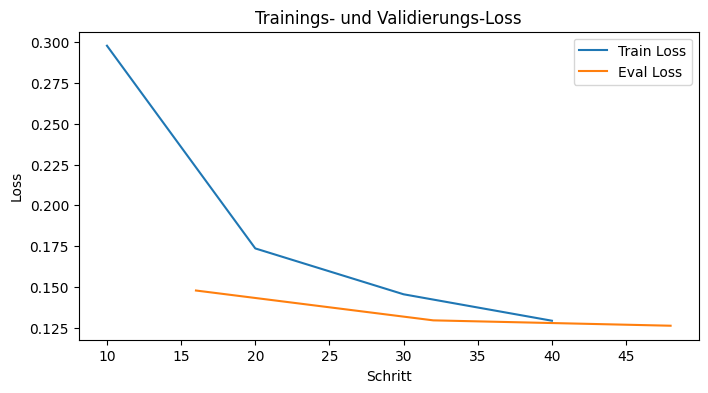

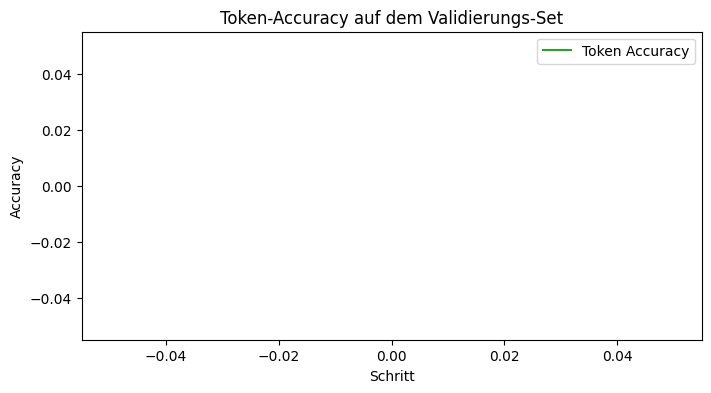

In [18]:
# 14 Graphische Evaluierung -> sobald trainer.train() durchgelaufen ist

import matplotlib.pyplot as plt

# Trainer-Log-History enthält zwischengespeicherte Werte
logs = trainer.state.log_history

# 1) Trainings-Loss
steps_train = [e["step"] for e in logs if "loss" in e]
train_loss  = [e["loss"] for e in logs if "loss" in e]

# 2) Validation-Loss
steps_eval = [e["step"] for e in logs if "eval_loss" in e]
eval_loss  = [e["eval_loss"] for e in logs if "eval_loss" in e]

# 3) Token-Accuracy
steps_acc   = [e["step"]           for e in logs if "token_accuracy" in e]
token_acc   = [e["token_accuracy"] for e in logs if "token_accuracy" in e]

# Plot 1: Train vs. Eval Loss
plt.figure(figsize=(8,4))
plt.plot(steps_train, train_loss, label="Train Loss")
plt.plot(steps_eval,  eval_loss,  label="Eval Loss")
plt.xlabel("Schritt")
plt.ylabel("Loss")
plt.title("Trainings- und Validierungs-Loss")
plt.legend()
plt.show()

# Plot 2: Token-Accuracy auf Val-Set
plt.figure(figsize=(8,4))
plt.plot(steps_acc, token_acc, label="Token Accuracy", color="tab:green")
plt.xlabel("Schritt")
plt.ylabel("Accuracy")
plt.title("Token-Accuracy auf dem Validierungs-Set")
plt.legend()
plt.show()

In [26]:
# 15 Inferenz Testing

from transformers import pipeline

# Falls du den Trainer noch in der Session hast:
trained_model = trainer.model
trained_tokenizer = tokenizer

# 🚀 Pipeline anlegen
pipe = pipeline(
    "text-generation",
    model=trained_model,
    tokenizer=trained_tokenizer,
    device_map="auto",        # oder device=0
    torch_dtype=torch.float16, # wenn du mit fp16 trainiert hast
    return_full_text = False
)

# 📝 Deinen Prompt definieren -> Prompt noch nicht gleich zum Training: Es fehlt noch Input und Output/n etc. !!!!!!!
prompt = (
    "### Instruction:\n"
        "From the input text, extract the following fields.\n"
        "Format your response as newline-separated entries:\n\n"
        "category: value\n\n"
        "Fields to extract:\n"
        "- risk_communication\n"
        "- single_case_base\n"
        "- absolute_risk_base\n"
        "- absolute_risk_new\n"
        "- absolute_number_base\n"
        "- absolute_number_new\n"
        "- absolute_risk_difference\n"
        "- relative_risk\n"
        "- absolute_number_difference\n"
        "- verbal_descriptor_base\n"
        "- verbal_descriptor_new\n"
        "- verbal_descriptor_change\n"
        "- population_size\n"
        "- reference_class_description_base\n"
        "- reference_class_description_new\n"
        "- reference_class_size_base\n"
        "- reference_class_size_new\n"
        "- source_base\n"
        "- source_new\n"
        "- topic_and_unit\n\n"
    "### Input:\n"
    "The risk of heart failure is 10%. The new abolsute risk is two times higher.\n\n"
    "### Output:\n"
)

# ▶️ Generieren
out = pipe(
    prompt,
    max_new_tokens=400,
    do_sample=False,
    temperature=0
)

print("🔍 Antwort:\n", out[0]["generated_text"])

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔍 Antwort:
 risk_communication: 1.0
single_case_base: 0.0
absolute_risk_base: 0.1
absolute_risk_new: null
absolute_number_base: null
absolute_number_new: null
absolute_risk_difference: null
relative_risk: 2.0
absolute_number_difference: null
verbal_descriptor_base: null
verbal_descriptor_new: null
verbal_descriptor_change: null
population_size: null
reference_class_size_base: null
reference_class_size_new: null
reference_class_description_base: null
reference_class_description_new: null
source_base: null
source_new: null
topic_and_unit: null

### Explanation:
The input text provides information about the risk of heart failure and the new absolute risk. The risk of heart failure is 10% and the new absolute risk is two times higher. The model extracts the following fields:
risk_communication: 1.0 (indicating the presence of risk communication in the input text)
single_case_base: 0.0 (indicating that the risk of heart failure is not based on a single case)
absolute_risk_base: 0.1 (the ris